## n-step TD prediction for random walk env

Random walk environment provided here is a Markov reward process, the transition between adjacent states are with a equal probability (i.e., 0.5 to the left and 0.5 to the right). Here we use this environment to reproduce the figure in Example 7.1.

In [1]:
from multiprocessing import Pool

import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from envs.random_walk import RandomWalkEnv

In [2]:
def run_episode(env, V, alpha, n, gamma=0.99):
    obs = env.reset()
    S = [obs]
    R = [None]

    t, T = 0, float('inf')
    while True:
        if t < T:
            next_obs, reward, done, _ = env.step()
            S.append(next_obs)
            R.append(reward)
            if done:
                T = t + 1
        tau = t - n + 1
        if tau >= 0:
            # Compute n-step return
            G = 0
            for i in range(tau + 1, min(tau + n, T) + 1):
                G += gamma**(i - tau - 1) * R[i]

            if tau + n < T:
                G = G + gamma**n * V[S[tau + n]]

            V[S[tau]] = V[S[tau]] + alpha * (G - V[S[tau]])
        if tau == T - 1:
            break
        t += 1

def run_episodes(episodes, alpha, n):
    V = np.zeros(19)
    for _ in range(episodes):
        env = RandomWalkEnv(19)
        run_episode(env, V, alpha, n)
    return V

def compute_true_value():
    '''The reward of the left-most is -1 and reward of the right-most is 1, thus the value of each state is:
    V(s) = -1 * p(left|s) + 1 * p(right|s)
    where, p(left|s) is the probability of starting from s ending at the left-most.
    Therefore, the state value of the center state is 0.
    '''
    values = [-0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
    return values

def run_experiment(alpha, n, true_V):
    all_rms = []
#     print("Run repetitions:")
    for _ in range(100):
        V = run_episodes(10, alpha, n)
        rms = np.sqrt(np.mean(np.square(true_V - V)))
        all_rms.append(rms)
    return np.mean(all_rms)

In [3]:
true_V = compute_true_value()
alphas = np.arange(0, 1.01, 0.05)
def compute_curve(n):
    results = []
    for alpha in alphas:
        average_rms = run_experiment(alpha, n, true_V)
        results.append(average_rms)
    return results

ns = [512, 256, 128, 64, 32, 16, 8, 4, 2, 1]
with Pool(10) as p:
    results = p.map(compute_curve, ns)

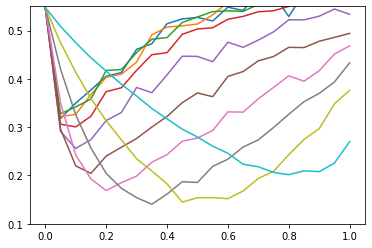

In [4]:
plt.ylim(0.1, 0.55)
for result in results:
    plt.plot(alphas, result)